In [1]:
from skeleton import *
from coco import KeyPoint
import matplotlib.pyplot as plt 
from model import *
import numpy as np

In [2]:
coco = Coco()
coco.load_annotations()

In [3]:
metadata_image = coco.get_metadata(6)
skeleton = Skeleton(
    img_shape=metadata_image['shape'],
    skeleton=metadata_image['skeleton'],
    keypoints=metadata_image['keypoints'],
    bbox=metadata_image['bbox'],
)
skeleton.sigma = 5

In [4]:
net = Net()
net.load_state_dict(torch.load('model.pt', map_location=torch.device('cpu'))['model'])
image = transforms.ToTensor()(Image.open(metadata_image['path']))

Using cache found in /home/brage/.cache/torch/hub/pytorch_vision_v0.10.0


In [37]:
def confidence_threshold(x):
    x[np.abs(x) < 0.3] = 0
    return x

In [6]:
confidence, paf = net(image.reshape((1, ) + image.shape))
keypoints = confidence.shape[1]

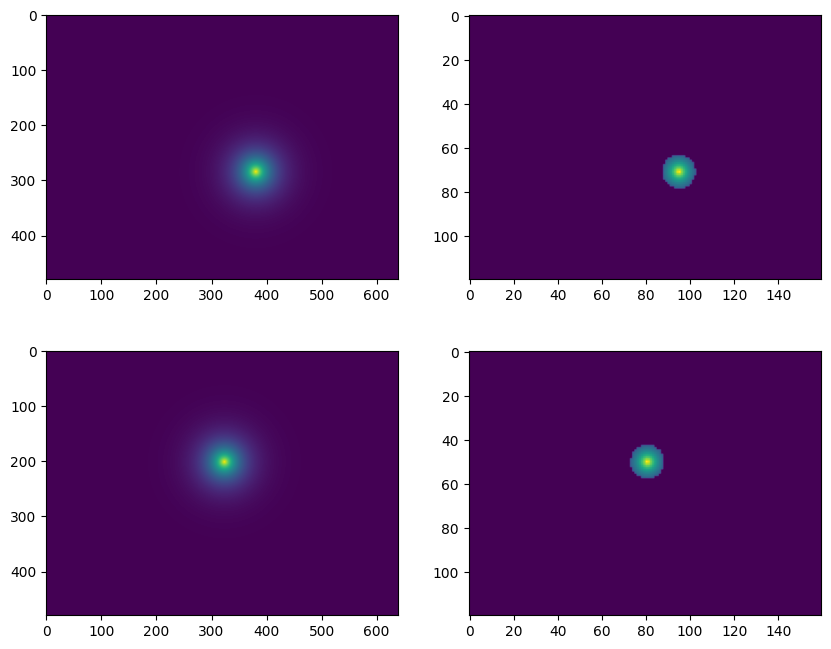

In [26]:
_, axarr = plt.subplots(2, 2, figsize=(10, 8))
#i = 3
skeleton_limb = metadata_image['skeleton'][3]
keypoint_a = skeleton_limb[0] -1
keypoint_b = skeleton_limb[1] -1

axarr[0][0].imshow(skeleton.confidence_map()[keypoint_a])
axarr[0][1].imshow(confidence_threshold(confidence[0][keypoint_a].detach().numpy()))
axarr[1][0].imshow(skeleton.confidence_map()[keypoint_b])
axarr[1][1].imshow(confidence_threshold(confidence[0][keypoint_b].detach().numpy()))


In [8]:
def merge_paf(predicted_paf, limbs):
    merged = torch.zeros((limbs, 480, 640, 2))
    for i in range(limbs):
        merged[i, :, :, 0] = (torch.abs(predicted_paf[0, 2 * i, :, :]).detach())#.reshape((120, 160))
        merged[i, :, :, 1] = (torch.abs(predicted_paf[0, 2 * i + 1, :, :]).detach())#.reshape((120, 160))
    return merged

def paf_threshold(x):
    x[np.abs(x) < 0.3] = 0
    return x

In [39]:
predicted_confidence = F.interpolate(
    confidence, size=(480, 640), mode='bilinear')
predicted_paf = F.interpolate(
    paf, size=(480, 640), mode='bilinear')

confidence_thresholded = predicted_confidence[0].detach().numpy()#.clone()
for i in range(confidence_thresholded.shape[0]):
    confidence_thresholded[i] = confidence_threshold(confidence_thresholded[i])
confidence_thresholded = torch.from_numpy(confidence_thresholded)
print(confidence_thresholded.shape)

paf_merged = merge_paf(
    predicted_paf,
    limbs=skeleton.paf_field().shape[0]
)
#print(paf_thresholded.shape)

paf_thresholded = paf_merged.detach().numpy()
for i in range(paf.shape[0]):
    paf_thresholded[i] = paf_threshold(paf_merged[i])
paf_thresholded = torch.from_numpy(paf_thresholded)
print(paf_thresholded.shape)

torch.Size([17, 480, 640])
torch.Size([19, 480, 640, 2])


In [10]:
paf_thresholded.shape
skeleton.confidence_map().shape

torch.Size([17, 480, 640])

### Model 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
index 0 is out of bounds for dimension 0 with size 0
index 0 is out of bounds for dimension 0 with size 0
1
1
1
1
1
1
index 0 is out of bounds for dimension 0 with size 0
1
index 0 is out of bounds for dimension 0 with size 0
1
index 0 is out of bounds for dimension 0 with size 0
index 0 is out of bounds for dimension 0 with size 0
index 0 is out of bounds for dimension 0 with size 0
index 0 is out of bounds for dimension 0 with size 0
index 0 is out of bounds for dimension 0 with size 0
1
1
[[1, tensor([286., 382.]), tensor([415., 391.])], [1, tensor([203., 323.]), tensor([286., 382.])], [1, tensor([203., 323.]), tensor([194., 271.])], [1, tensor([194., 271.]), tensor([ 74., 311.])], [1, tensor([203., 323.]), tensor([ 79., 379.])], [1, tensor([ 79., 379.]), tensor([ 74., 311.])], [1, tensor([147., 415.]), tensor([ 79., 379.])], [1, tensor([191., 450.]), tensor([147., 415.])], [1, tensor([ 74., 311.

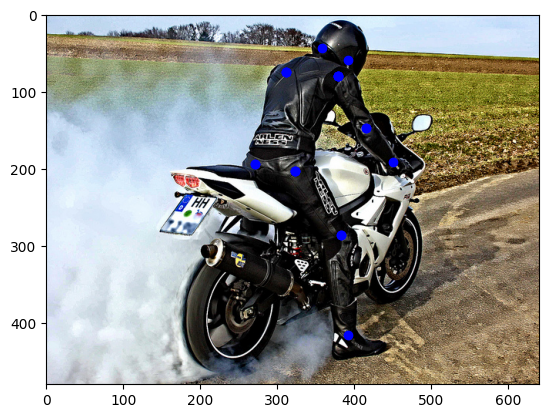

In [40]:
%load_ext autoreload
%autoreload 2
skeleton = Skeleton(
    img_shape=metadata_image['shape'],
    skeleton=metadata_image['skeleton'],
    keypoints=metadata_image['keypoints'],
    bbox=metadata_image['bbox'],
)
skeleton.sigma = 5

items = list(skeleton.merge(
    confidence_thresholded, 
    paf_thresholded,
))
print(items)
coco.results[6].plot_image_skeleton_keypoints(items, draw_skeleton=False)

## Real

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
index 0 is out of bounds for dimension 0 with size 0
index 0 is out of bounds for dimension 0 with size 0
1
1
1
1
1
1
index 0 is out of bounds for dimension 0 with size 0
1
index 0 is out of bounds for dimension 0 with size 0
1
index 0 is out of bounds for dimension 0 with size 0
index 0 is out of bounds for dimension 0 with size 0
index 0 is out of bounds for dimension 0 with size 0
index 0 is out of bounds for dimension 0 with size 0
index 0 is out of bounds for dimension 0 with size 0
1
1


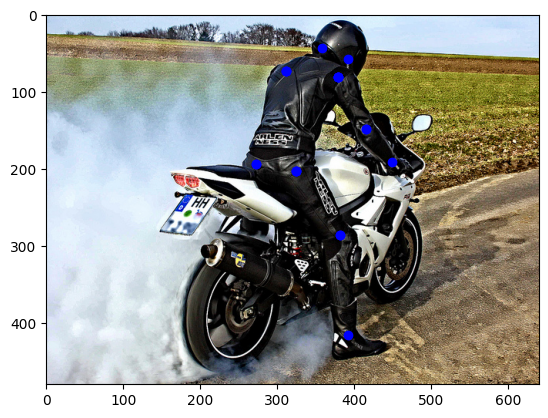

In [31]:
%load_ext autoreload
items = list(skeleton.merge(
    skeleton.confidence_map(), 
    paf_thresholded,
#    keypoint=3
))
coco.results[6].plot_image_skeleton_keypoints(items, draw_skeleton=False)